In [1]:
import numpy as np
import pandas as pd
from src.measurements import Measurements
from src.run import sample_measurement
from src.config import Config
from src.posterior import Posterior
import warnings

warnings.filterwarnings('ignore')

Organization for helpful written instructions:
 - things you need to change
 - input check information
 - outputs and diagnostics
 - commentary about what to look for (red flags and green)

# Shouldn't use if mass loss in your measurements is >50%
# other pre-input QA/QC notes
# if you make change in files, re-run all the cells etc.

In [2]:
DATAFILE = 'data/Ruyle_Cape_Cod_rivers.csv'
SAMPLE_NUMBER = 18

In [3]:

df = pd.read_csv(DATAFILE)
df.head()

,Sample,Citation,Units,config,C3,C4,C5,C6,C7,PFOS,...,C6MDL,C7MDL,PFOSMDL,C3err,C4err,C5err,C6err,C7err,C8err,PFOSerr
0,MPSC_20180711,"Ruyle et al., 2021",nM,AFFF_impacted.yaml,0.0748,0.0904,0.5688,0.0074,0.0099,0.1719,...,0.0021,0.0003,0.0002,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,JPNB_20180712,"Ruyle et al., 2021",nM,AFFF_impacted.yaml,0.0385,0.0151,0.0737,0.0061,0.0000,0.1233,...,0.0021,0.0003,0.0002,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,JPSB_20180712,"Ruyle et al., 2021",nM,AFFF_impacted.yaml,0.0384,0.0210,0.0751,0.0047,0.0000,0.1235,...,0.0021,0.0003,0.0002,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,QR01_20180710,"Ruyle et al., 2021",nM,AFFF_impacted.yaml,0.0156,0.0261,0.0856,0.0035,0.0054,0.1396,...,0.0021,0.0003,0.0002,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,QR02_20180710,"Ruyle et al., 2021",nM,AFFF_impacted.yaml,0.0316,0.0427,0.1488,0.0069,0.0010,0.2409,...,0.0021,0.0003,0.0002,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [4]:
sample_name = df['Sample'][SAMPLE_NUMBER]
print('Sample ' + sample_name)
df_row = df.iloc[SAMPLE_NUMBER]
measurements = Measurements.from_row(df_row)
measurements.print()

Sample MC01_20180711
PFCAs: {   'C3': Measurement(value=0.0843, error=0.1, MDL=0.002),
    'C4': Measurement(value=0.075, error=0.1, MDL=0.0026),
    'C5': Measurement(value=0.086, error=0.1, MDL=0.0013),
    'C6': Measurement(value=0.0127, error=0.1, MDL=0.0021),
    'C7': Measurement(value=0.0, error=0.1, MDL=0.0003)}
targeted_precursors: {}
PFOS: Measurement(value=0.0901, error=0.1, MDL=0.0002)
associated_config: 'config/AFFF_impacted.yaml'


In [5]:
config = Config.from_yaml(measurements.associated_config)
prior_name = config.prior_name
config.print()

Config object:
{   'ecf_relativechain_yield_errors': [0, 0.1144, 0.0089, 0, 0, 0, 0, 0],
    'ecf_relativechain_yields': [0, 0.869, 0.0085, 0, 0, 0, 0, 0],
    'ft_relativechain_yield_errors': [   0.0065,
                                         0.0721,
                                         0.0435,
                                         0.0207,
                                         0.0171,
                                         0.0252,
                                         0,
                                         0],
    'ft_relativechain_yields': [   0.0245,
                                   0.185,
                                   0.2874,
                                   0.1943,
                                   0.1425,
                                   0.0867,
                                   0,
                                   0],
    'jeffreys_variance': None,
    'possible_precursors': [   '4:2 FT',
                               '6:2 FT',
              

In [6]:
# Sampling options:
TARGET_EFFECTIVE_STEPS = 2500 # the "effective sample size" desired, which accounts for autocorrelation in raw samples.
MAX_STEPS = 250000
alpha = 0.55#-1 # if this is a number less than zero, the sampler will tune alpha to find an efficient acceptance rate.
MAX_DEPTH = 3 # the depth of search in the alpha-tuning process; will have no effect if alpha is set > 0.


In [7]:
posterior = sample_measurement(config, measurements,
                                 prior_name=prior_name,
                                 Nincrement=2500,
                                 TARGET_EFFECTIVE_STEPS=TARGET_EFFECTIVE_STEPS,
                                 MAX_STEPS=MAX_STEPS,
                                 MAX_DEPTH=MAX_DEPTH,
                                 alpha=alpha)
posterior.save('infer_out/test')

Sampling prior.
acceptance rate is 0.22 when alpha is 0.55
Sampling posterior in 2500-iteration increments.
After 2500 iterations, autocorr time: unavailable
After 5000 iterations, autocorr time: unavailable
After 7500 iterations, autocorr time: unavailable
After 10000 iterations, autocorr time: unavailable
After 12500 iterations, autocorr time: unavailable
After 15000 iterations, autocorr time: unavailable
After 17500 iterations, autocorr time: unavailable
After 20000 iterations, autocorr time: unavailable
After 22500 iterations, autocorr time: unavailable
After 25000 iterations, autocorr time: unavailable
After 27500 iterations, autocorr time: unavailable
After 30000 iterations, autocorr time: unavailable
After 32500 iterations, autocorr time: unavailable
After 35000 iterations, autocorr time: unavailable
After 37500 iterations, autocorr time: unavailable
After 40000 iterations, autocorr time: unavailable
After 42500 iterations, autocorr time: unavailable
After 45000 iterations, auto

In [8]:
posterior = Posterior.from_saved('infer_out/test')

In [9]:
summary = posterior.summary_table()
summary

,Statistic,4:2 FT,6:2 FT,8:2 FT,C4 ECF,C5 ECF,C6 ECF,C7 ECF,C8 ECF,Total precursors
0,Mean,0.021639,0.149991,0.002678,0.010416,0.005775,0.036903,0.000869,0.001166,0.458873
1,Geometric mean,0.000656,0.100037,0.000095,0.006502,0.003471,0.023379,0.000470,0.000738,0.427276
2,5.0th percentile,0.000002,0.005857,0.000002,0.001912,0.000921,0.006992,0.000092,0.000219,0.210470
3,25.0th percentile,0.000037,0.102663,0.000012,0.003178,0.001690,0.011400,0.000231,0.000363,0.348055
4,50.0th percentile,0.000684,0.160858,0.000078,0.005555,0.003008,0.019897,0.000434,0.000632,0.448323
5,75.0th percentile,0.012738,0.207844,0.000626,0.011757,0.006494,0.042216,0.000947,0.001332,0.540701
6,95.0th percentile,0.141904,0.247308,0.010329,0.037900,0.021066,0.134029,0.003280,0.004191,0.774495


# add language about what means when geomeans/quantiles don't sum to their total equivalent

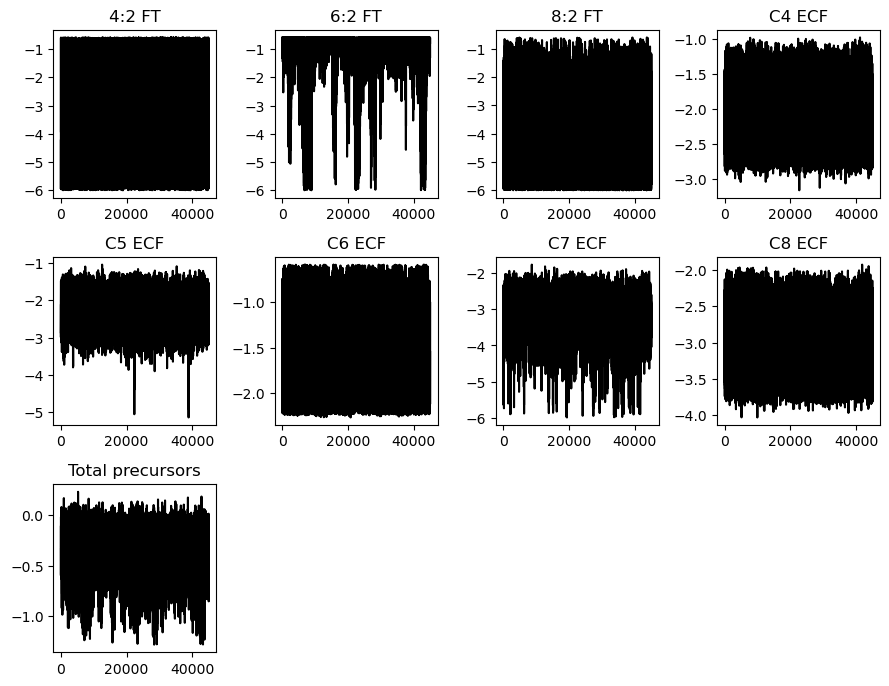

In [10]:
posterior.show_traces()

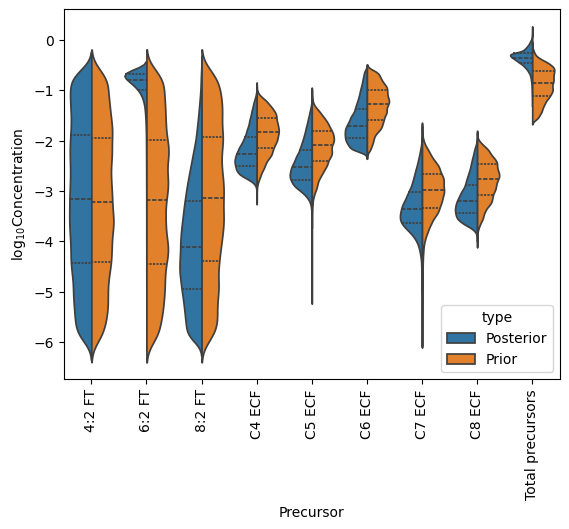

In [11]:
posterior.marginalplot()

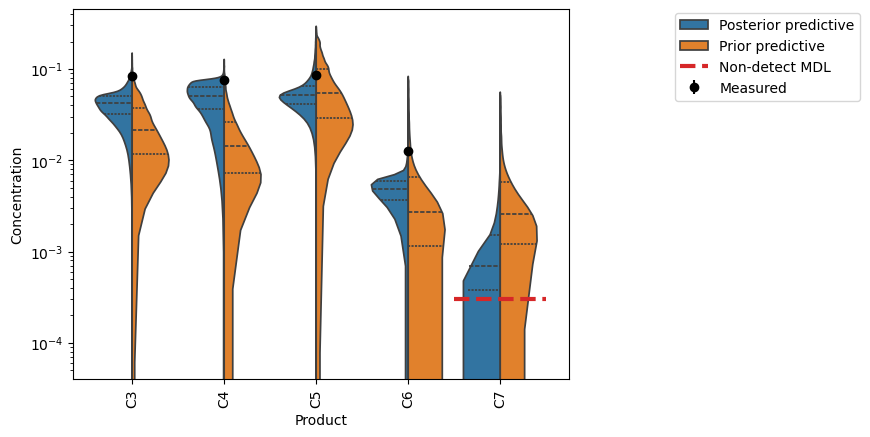

In [12]:
posterior.posterior_predictive()

In [13]:
measurements

Measurements(PFCAs={'C3': Measurement(value=0.0843, error=0.1, MDL=0.002), 'C4': Measurement(value=0.075, error=0.1, MDL=0.0026), 'C5': Measurement(value=0.086, error=0.1, MDL=0.0013), 'C6': Measurement(value=0.0127, error=0.1, MDL=0.0021), 'C7': Measurement(value=0.0, error=0.1, MDL=0.0003)}, targeted_precursors={}, PFOS=Measurement(value=0.0901, error=0.1, MDL=0.0002), associated_config='config/AFFF_impacted.yaml')